In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from matplotlib import cm

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
import seaborn as sns

import sys
sys.path.insert(0, '../scr')
from transformers import SelectFeatures, Impute, select_city,create_lagged_column, logtransform_target, inverse_logtransform_target,deal_with_missing_values, create_min_yearly_temp

### Load the provided data

In [2]:
train_features = pd.read_csv('../data/dengue_features_train.csv',
                             index_col=[0,1,2])
train_labels = pd.read_csv('../data/dengue_labels_train.csv',
                           index_col=[0,1,2])
test_features = pd.read_csv('../data/dengue_features_test.csv',
                             index_col=[0,1,2])

### Splitting the provided training data by city and into train and validation data for each city

In [3]:
# initialize dictionaries to hold the train and validation data for each city
full_train_X = {}
test_X = {}
train_X = {}
validate_X = {}
full_train_y = {}
train_y = {}
validate_y = {}
cities = ['sj', 'iq']
city_names = {'sj':'San Juan, Puerto Rico', 'iq':'Iquitos, Peru' }

# make the train validation split
for city in cities:
    full_train_X [city] = select_city(train_features, city = city)
    full_train_y [city] = select_city(train_labels, city = city)
    test_X [city] = select_city(test_features, city = city)
    
    assert len(full_train_X [city]) == len(full_train_y [city])
    
    split_idx = int(len(full_train_X[city])*0.8)
    
    train_X [city] = full_train_X [city].head(split_idx)
    train_y [city] = full_train_y [city].head(split_idx)
    
    validate_X [city] = full_train_X [city].tail(len(full_train_X[city]) - split_idx)
    validate_y [city] = full_train_y [city].tail(len(full_train_y[city]) - split_idx)
    

Check that the split worked

In [4]:
for city in cities:
    print('------------- '+city_names[city]+' -----------------')
    print("training")
    print('X', train_X[city].shape, 'y', train_y[city].shape)
    print('validation')
    print('X', validate_X[city].shape, 'y', validate_y[city].shape)
    print('all')
    print('X', full_train_X[city].shape, 'y', full_train_y[city].shape,'\n')

------------- San Juan, Puerto Rico -----------------
training
X (748, 21) y (748, 1)
validation
X (188, 21) y (188, 1)
all
X (936, 21) y (936, 1) 

------------- Iquitos, Peru -----------------
training
X (416, 21) y (416, 1)
validation
X (104, 21) y (104, 1)
all
X (520, 21) y (520, 1) 



### Select which features we want to look at time-lagged

In [5]:
myfeatures = ['station_precip_mm', 
                 'station_min_temp_c',
             'station_max_temp_c']

myfeatures = [x for x in train_X['sj'].columns if x!='week_start_date']

In [6]:
extended_train_X = train_X.copy()

for city in cities:
    extended_train_X[city]['total_cases'] = train_y[city].total_cases
    for feat in myfeatures:
        for l in range(0,54):
            extended_train_X[city] = create_lagged_column(extended_train_X[city],feat,lag=l)
    
#hlp['target']=train_y['sj']
#    corr[city]=hlp.corr()


/tmp/ipykernel_230710/3887468152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extended_train_X[city]['total_cases'] = train_y[city].total_cases


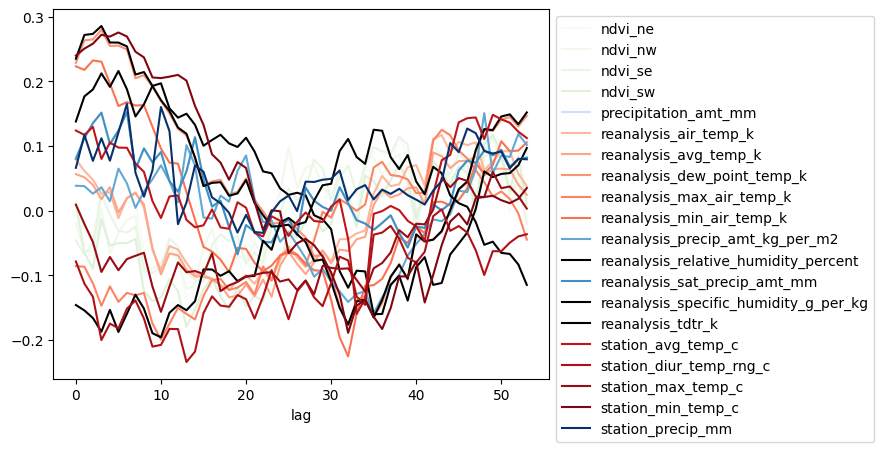

In [7]:
corr = extended_train_X['iq'].corr()['total_cases']
cmap = cm.get_cmap('Reds')
temp_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Blues')
preci_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Greens')
ndvi_colors = cmap(np.linspace(0,1,20))
i=0
for feature in myfeatures:
    data=[]
    for l in range(0,54):
        data.append([l,corr[feature+f'_lagged_{l:1.2f}']])
    data=np.array(data)
    if 'temp' in feature:
        color=temp_colors[i]
    elif 'preci' in feature:
        color=preci_colors[i]
    elif 'ndvi' in feature:
        color=ndvi_colors[i]
    else:
        color='k'
    plt.plot(data[:,0],data[:,1],label=feature,color=color)
    i+=1
plt.gca().set_xlabel('lag')
plt.gca().legend(bbox_to_anchor=(1,1))

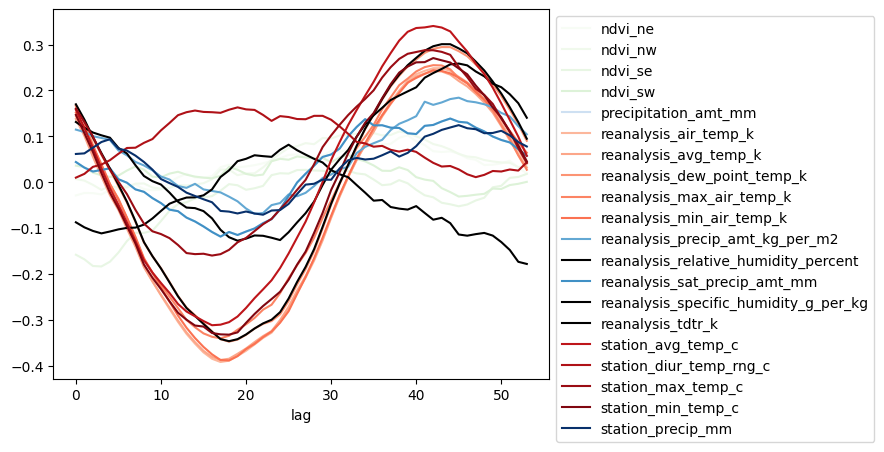

In [9]:
corr = extended_train_X['sj'].corr()['total_cases']
cmap = cm.get_cmap('Reds')
temp_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Blues')
preci_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Greens')
ndvi_colors = cmap(np.linspace(0,1,20))
i=0
for feature in myfeatures:
    data=[]
    for l in range(0,54):
        data.append([l,corr[feature+f'_lagged_{l:1.2f}']])
    data=np.array(data)
    if 'temp' in feature:
        color=temp_colors[i]
    elif 'preci' in feature:
        color=preci_colors[i]
    elif 'ndvi' in feature:
        color=ndvi_colors[i]
    else:
        color='k'
    plt.plot(data[:,0],data[:,1],label=feature,color=color)
    i+=1
plt.gca().set_xlabel('lag')
plt.gca().legend(bbox_to_anchor=(1,1))

In [ ]:
fig,ax=plt.subplots(1)
a.plot(y='min_yearly_temp',ax=ax)
a.plot(y='station_min_temp_c',ax=ax)

In [ ]:
test['target']=train_y['sj']

In [ ]:
sns.heatmap(test.corr(),vmax=0.3)

### Training one model per city

In [ ]:
model={} # we train one model per city and save them in this dictionary
for city in cities:
    model[city] = this_pipe.fit(train_X[city], train_y[city])

### Predicting on training and validation data set for each city

In [ ]:
pred_train = {}
pred_valid = {}

for city in cities:
    pred_train[city] = model[city].predict(train_X[city])
    pred_valid[city] = model[city].predict(validate_X[city])

### Quality of the model

In [ ]:
print('MEAN ABSOLUTE ERROR\n')
for city in cities:
    print('------ '+city_names[city]+' ---------')
    print(f'Training:   {mean_absolute_error(train_y[city], pred_train[city]):1.4f}')
    print(f'Validation: {mean_absolute_error(validate_y[city], pred_valid[city]):1.4f}\n')

In [ ]:
# maybe here, we could save the pipeline and the errors and hyper parameters (and later also a plot)?

### Plot of predictions

In [ ]:
# attention, attention, this really depends on pandas and everyone not mixing up the rows

training_results = {}
validation_results = {}

# setting up figure with subplots
fig, axes = plt.subplots(2, 2, gridspec_kw = {'width_ratios':[2.5, 1]})
fig.set_size_inches(14,8)  
axes = axes.flatten()
for i in range(4):
    axes[i].spines['top'].set_visible(False)
    if i%2:
        axes[i].yaxis.tick_right()
        axes[i].spines['left'].set_visible(False)
        axes[i].yaxis.set_label_position("right")
    else:
        axes[i].spines['right'].set_visible(False)        
        
plt.subplots_adjust(hspace = 0.75, wspace = 0.08)

# combine the prediction and true values in one dataframe
for city in cities:
    training_results[city] = train_y[city]
    training_results[city]['pred'] = pred_train[city]
    validation_results[city] = validate_y[city]
    validation_results[city]['pred'] = pred_valid[city]

# plot the predictions and true values for each city and each data set (training/validation)
for i, city in enumerate(cities):
    training_results[city].plot(y = ['total_cases', 'pred'], ax = axes[2*i], 
                                label = ['True', 'Prediction'], color = ['.75','orangered'])
    validation_results[city].plot(y = ['total_cases','pred'], ax = axes[2*i+1], 
                                  label = ['True','Prediction'], color = ['.75','b'])
    axes[2*i].set_title(city_names[city])
    axes[2*i].set_ylim(0,full_train_y[city].total_cases.max())
    axes[2*i+1].set_ylim(0,full_train_y[city].total_cases.max())
    
# format axes
legend_title=['Training data','Validation data']*2
for i in range(4):
    axes[i].set_ylabel('cases')
    axes[i].set_xlabel('time (year, week)')
    axes[i].legend(frameon=False, title = legend_title[i], loc = i%2+1)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_facecolor('.98')

### Predict the test data set

In [ ]:
pred_test = {}
for city in cities:
    pred_test[city] = model[city].predict(test_X[city])

### Get the prediction into the right format for submission

In [ ]:
results = []
for city in cities:
    df_hlp = test_X[city].copy()
    df_hlp['total_cases'] = pred_test[city]
    df_hlp = pd.concat([df_hlp], keys=[city], names=['city'])
    results.append(pd.DataFrame(df_hlp.total_cases.astype(int)))
final = pd.concat(results)
final.to_csv('../predictions/prediction.csv')